This is a small geocomputational scripting exercise for an applicaztion at iDiv.

*(cc) jackisch@kit.edu 2018*

----

## Monthly means of MODIS Land Surface Temperature

*Task:* Derive global MODIS/Terra and MODIS/Aqua Land Surface Temperature maps for monthly means and export as GeoTIFF. Discard any pixels where the quality indicator >0.

In [1]:
#preamble
%pylab inline
import pandas as pd
import numpy as np

import requests
from osgeo import gdal
from bs4 import BeautifulSoup
from pyhdf import SD

#import seaborn as sns
#sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rasterio as rst
from rasterio.merge import merge
from rasterio.plot import show

In [3]:
import os.path
import multiprocessing


### Functions to load and process MODIS data tile-wise and to mosaic them afterwards
The following sequence of functions does the requested analysis and data collection. The processing has been chosen to happen tile-wise for easier parallelisation at the level of one individual month.

In [4]:
# get a series of folders in modis product with timestamp index:
def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def get_modis_folder_cont(d_mod):
    #get all folders in https repository:
    f_mod = listFD(d_mod,'')[7:] #this is specific for current folder structure. if changed, a dynamic index check is required

    #create time index for retrieval of records in specific time span:
    tsx= pd.to_datetime(f_mod[0].split('//')[-1][:-1],format='%Y.%m.%d')
    ts_mod = np.repeat(tsx,len(f_mod))

    for i in np.arange(len(f_mod)):
        ts_mod[i] = pd.to_datetime(f_mod[i].split('//')[-1][:-1],format='%Y.%m.%d')

    return pd.Series(f_mod,index=ts_mod)

In [5]:
#MODIS file repository addresses
d_modA2 = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.006/'
d_mydA2 = 'https://e4ftl01.cr.usgs.gov/MOLA/MYD11A2.006/'

#get folders with timestamp
ds_modA2 = get_modis_folder_cont(d_modA2)
ds_mydA2 = get_modis_folder_cont(d_mydA2)

#get files for specific month
fi_terra = listFD(ds_modA2[ds_modA2.index[(ds_modA2.index.year == 2002) & (ds_modA2.index.month == 8)]].values[0],'hdf')
fi_aqua = listFD(ds_mydA2[ds_mydA2.index[(ds_mydA2.index.year == 2002) & (ds_mydA2.index.month == 8)]].values[0],'hdf')

In [6]:
#get tile files in month
def get_tile_files(fo,yr,mo):
    '''get all files of a MODIS product folder for a given year and month
    fo is the folder
    yr is the year as int
    mo is the month as int
    a Pandas Series with all tile files is returned'''
    fi = []
    for foo in fo[fo.index[(fo.index.year == yr) & (fo.index.month == mo)]].values:
        fi = np.append(fi, listFD(foo,'hdf'))

    # get tile index
    dummy = np.zeros(len(fi))
    for i in np.arange(len(fi)):
        dummy[i] = int(fi[i].split('.')[8][1:3])*100 + int(fi[i].split('.')[8][4:])

    return pd.Series(fi,index=dummy.astype(int))


In [7]:
#credentials for usgs https server (ftp server was shut down recently)
username = 'cojack'
password = 'RMn-GE9-D8z-qaq'

#download files to tmp folder:
def download_fi(path_series,tmpf='tmp/'):
    '''download hdf files from USGS https server to tmp folder
    path_series is a Pandas Series of the file paths in the repository
    tmpf indicates the path to store the files
    an array of the stored paths is returned'''
    path_array = path_series.values.astype(str)
    store_path = path_array
    k=0
    with requests.Session() as session:
        session.auth = (username, password)
        for url in path_array:
            fi_n = tmpf+str(url.split('/')[-1])
            if os.path.isfile(fi_n)==False:
                r1 = session.request('get', url)
                r = session.get(r1.url, auth=(username, password))
                with open(fi_n, "wb") as code:
                    code.write(r.content)
            store_path[k]=fi_n
            k+=1
            #test data file
            try:
                gdal_dataset = gdal.Open(fi_n)
                subsets = gdal_dataset.GetSubDatasets()
                gdal_dataset=None
            except:
                #try to reload data file once
                r = session.get(r1.url, auth=(username, password))
                with open(fi_n, "wb") as code:
                    code.write(r.content)
                try:
                    gdal_dataset = gdal.Open(fi_n)
                    subsets = gdal_dataset.GetSubDatasets()
                    gdal_dataset=None
                except:
                    print(fi_n + ' repeatedly failed to load and open properly')
            
    return store_path


In [51]:
def save_raster (raster_data, output_name, dataset, NaN_Value):
    '''save a np.array using GDAL to a GeoTiff file
    raster_data is a np.array
    output_name is the file to store
    dataset is a GDAL-accesible dataset to collect the projection and geotransform from
    NaN_Value defines what is placed
    '''
    # Open the reference dataset
    g = (dataset)
    # Get the Geotransform vector
    geo_transform = g.GetGeoTransform()
    x_size = g.RasterXSize # Raster xsize
    y_size = g.RasterYSize # Raster ysize
    srs = 'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"],AUTHORITY["EPSG","3857"]]'
    #srs = g.GetProjectionRef () # Projection
    #raster_data = g.ReadAsArray().astype(float)
    NaN_rast = NaN_Value
    # raster_data[raster_data == NaN_rast] = 'NaN'
    raster_data[raster_data == NaN_rast] = np.nan
    # Need a driver object. By default, we use GeoTIFF
    dst_options = ['COMPRESS=LZW']
    driver = gdal.GetDriverByName("GTiff")
    dataset_out = driver.Create(output_name, x_size, y_size, 1, gdal.GDT_Float32, dst_options)
    dataset_out.SetGeoTransform(geo_transform)
    dataset_out.SetProjection(srs)
    dataset_out.GetRasterBand(1).WriteArray(raster_data.astype(np.float32))
    dataset_out.FlushCache()
    
    return

def save_raster_comp (raster_data, bands, output_name, dataset, NaN_Value):
    '''save a np.array using GDAL to a GeoTiff file
    raster_data is a np.array
    output_name is the file to store
    dataset is a GDAL-accesible dataset to collect the projection and geotransform from
    NaN_Value defines what is placed
    '''
    # Open the reference dataset
    g = (dataset)
    # Get the Geotransform vector
    geo_transform = g.GetGeoTransform()
    x_size = g.RasterXSize # Raster xsize
    y_size = g.RasterYSize # Raster ysize
    srs = 'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"],AUTHORITY["EPSG","3857"]]'
    #srs = g.GetProjectionRef () # Projection
    #raster_data = g.ReadAsArray().astype(float)
    NaN_rast = NaN_Value
    # raster_data[raster_data == NaN_rast] = 'NaN'
    # Need a driver object. By default, we use GeoTIFF
    dst_options = ['COMPRESS=LZW']
    driver = gdal.GetDriverByName("GTiff")
    dataset_out = driver.Create(output_name, x_size, y_size, bands, gdal.GDT_Float32, dst_options)
    dataset_out.SetGeoTransform(geo_transform)
    dataset_out.SetProjection(srs)
    for b in np.arange(bands):
        rst = raster_data[:,:,b]
        rst[rst == NaN_rast] = np.nan
        dataset_out.GetRasterBand(b+1).WriteArray(rst.astype(np.float32))
    dataset_out.FlushCache()
    
    return
    

In [53]:
#read and process set of terra and aqua tiles
#store to GeoTiff
    
def tile_process(fi_terra,fi_aqua,ti):
    '''Processing of one tile over one month
    fi_terra and fi_aqua are the respective file arrays
    ti is the tile index
    
    This function calls to download the hdf files. 
    It then extracts the required LST data and QC indicees.
    A np.array is filled with the requested data.
    The mean values for day and night are stored to two GeoTiff files.'''
    
    store_path_terr = download_fi(fi_terra[ti])
    store_path_aqua = download_fi(fi_aqua[ti])
    
    # create empty arrays
    dt_arr = np.zeros((1200,1200,len(store_path_terr)))
    nt_arr = np.zeros((1200,1200,len(store_path_terr)))
    da_arr = np.zeros((1200,1200,len(store_path_terr)))
    na_arr = np.zeros((1200,1200,len(store_path_terr)))


    # get data from terrestial LST
    for i in np.arange(len(store_path_terr)):
        
        try:
            # load layers from hdf4 file
            gdal_dataset = gdal.Open(store_path_terr[i])
            subsets = gdal_dataset.GetSubDatasets()
            dataset_LSTd = gdal.Open(subsets[0][0])
            qc_LSTd = gdal.Open(subsets[1][0])
            dataset_LSTn = gdal.Open(subsets[4][0])
            qc_LSTn = gdal.Open(subsets[5][0])
        
            # populate array with data where the criterion (QC = 0) is met
            dummy = dataset_LSTd.ReadAsArray().astype(float)
            dummy[qc_LSTd.ReadAsArray()>0] = np.nan
            dt_arr[:,:,i] = dummy
            dummy = dataset_LSTn.ReadAsArray().astype(float)
            dummy[qc_LSTn.ReadAsArray()>0] = np.nan
            nt_arr[:,:,i] = dummy
        except:
            print('Error while reading '+store_path_terr[i]+'.')
            print('Tile data not considered.')
            dt_arr[:,:,i] = np.nan
            nt_arr[:,:,i] = np.nan

    # get data from aquatic LST
    for i in np.arange(len(store_path_aqua)):
        
        try:
            # load layers from hdf4 file
            gdal_dataset = gdal.Open(store_path_aqua[i])
            subsets = gdal_dataset.GetSubDatasets()
            dataset_LSTd = gdal.Open(subsets[0][0])
            qc_LSTd = gdal.Open(subsets[1][0])
            dataset_LSTn = gdal.Open(subsets[4][0])
            qc_LSTn = gdal.Open(subsets[5][0])
            
            # populate array with data where the criterion (QC = 0) is met
            dummy = dataset_LSTd.ReadAsArray().astype(float)
            dummy[qc_LSTd.ReadAsArray()>0] = np.nan
            da_arr[:,:,i] = dummy
            dummy = dataset_LSTn.ReadAsArray().astype(float)
            dummy[qc_LSTn.ReadAsArray()>0] = np.nan
            na_arr[:,:,i] = dummy
        except:
            print('Error while reading '+store_path_aqua[i]+'.')
            print('Tile data not considered.')
            da_arr[:,:,i] = np.nan
            na_arr[:,:,i] = np.nan

    # calculate mean of LST records in time window
    d_arr_out = np.zeros((1200,1200,2))
    n_arr_out = np.zeros((1200,1200,2))
    d_arr_out[:,:,0] = np.nanmean(dt_arr,axis=2)
    d_arr_out[:,:,1] = np.nanmean(da_arr,axis=2)
    n_arr_out[:,:,0] = np.nanmean(nt_arr,axis=2)
    n_arr_out[:,:,1] = np.nanmean(na_arr,axis=2)

    #save_raster (d_arr_out, 2, 'res/'+str(ti).zfill(4)+'_d.tif', dataset_LSTd, 0)
    #save_raster (n_arr_out, 2, 'res/'+str(ti).zfill(4)+'_n.tif', dataset_LSTn, 0)
    save_raster_comp (d_arr_out,2, 'res/'+str(ti).zfill(4)+'_d.tif', dataset_LSTd, 0)
    save_raster_comp (n_arr_out,2, 'res/'+str(ti).zfill(4)+'_n.tif', dataset_LSTd, 0)
    
    return ['res/'+str(ti).zfill(4)+'_d.tif', 'res/'+str(ti).zfill(4)+'_n.tif']


In [20]:
def mosaic_Gtif(tis,out_fi='mos.tif'):
    '''Mosaic GeoTiff files
    tis is a list of GeoTiff files to be stitched together
    out_fi is the name of the output GeoTiff file
    '''
    
    mos_fi = tis#['test1.tif','test2.tif']
    fi_to_mosaic = []
    for fi in mos_fi:
        sx = rst.open(fi)
        fi_to_mosaic.append(sx)
    
    mosaic, out_trans = merge(fi_to_mosaic)
    show(mosaic)

    # write mosaic to file
    out_meta = sx.meta.copy()
    out_meta.update({"driver": "GTiff","height": mosaic.shape[1],"width": mosaic.shape[2],"transform": out_trans,"compress": "LZW","crs": "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"})
    #'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
    #"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
    
    with rst.open(out_fi, "w", **out_meta) as dest:
        dest.write(mosaic)
        
    return

In [11]:
#identifiers of tiles which contain land (317)
land_tiles = pd.read_csv('land_tiles.txt',header=None,index_col=0)
land_tiles.columns = ['istr']
land_tiles.head(5)

,istr
0,
8,h08v00
9,h09v00
10,h10v00
107,h07v01
108,h08v01


## Actually run the analysis for a specific month and year

In [21]:
yr = 2004
mo = 8

fi_terra = get_tile_files(ds_modA2,yr,mo)
fi_aqua = get_tile_files(ds_mydA2,yr,mo)

def wrap_tile_process(ti):
    #if os.path.isfile('./res/'+str(ti).zfill(4)+'_d.tif')==False:
    try:
        tile_process(fi_terra,fi_aqua,ti)
    except:
        print(ti+' could not be processed')
    return

In [55]:
#parallel version:
try:
    pool = multiprocessing.Pool()
    results = pool.map(wrap_tile_process, np.unique(fi_terra.index).tolist())
except:
    pool.close()
pool.close()

/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/cojack/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:80: R

In [ ]:
#sequential version:
#NO NEED TO RUN IF PARALLEL VERSION WORKS
for ti in np.unique(fi_terra.index):
    #if os.path.isfile('./res/'+str(ti).zfill(4)+'_d.tif')==False:
    try:
        tile_process(fi_terra,fi_aqua,ti)
    except:
        print('Tile '+str(ti)+' could not be processed')

## Generate mosaic output
(this uses all apparent ouput tiles)

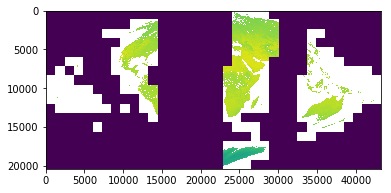

In [42]:
tis = !ls res/*d.tif
mosaic_Gtif(tis,out_fi='mos_082004d.tif')

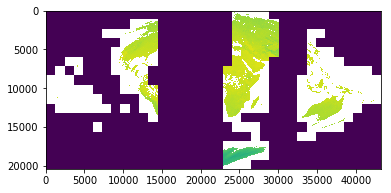

In [43]:
tis = !ls res/*n.tif
mosaic_Gtif(tis,out_fi='mos_082004n.tif')

This rough script should do the requested job. However, due testing, more elegant solutions and clean-up of the scattered intermediate files is pending.

### Some comments on and discussion of the found solutions
Although one task has been to download the full data archive, I had not sufficient resources at hand to do so. If one would like to really download the full repository, the https port is the only one available through scripting. The ftp server has been shut down. The respective *download_fi* function would need to be updated to be capable of longer autheification sessions. Alternatively, the earthengine api might be worth exploring.

I chose python as the language I currently use most. In some cases simple bash scripting might have made things easier. However, through the python code (once copied to a proper module) transfer to an HPC should be rather straight forward (given that all required packages are available).

Since MODIS is stored in hdf4 and since the files were not remotely accessible with the tools I tested, downloading the files and extracting the respective layers might not be the most elegant solution. With more time, I would try to batch-convert the hdf4 files to hdf5 and use more modern tools to access the data.

As proposed, the code is exemplary. By defining year and month exploring the full MODIS data set should be just a matter of time and HD space. 

Possible gap filling should depend on the repective application. In some ways, interpolation might be a reasonable choice. In others a reference to the similar behaving locations and a kind of maxLik estimate might be more suitable. 


**Please note, this code is not intended for productive application.** Due testing and cleaning is pending. The code is intended as experimental and educational only. In case of questions, contact me: jackisch@kit.edu